# Installation of required packages

In [1]:
!pip install foscat
!pip install git+https://github.com/xarray-contrib/xdggs.git


  Using cached foscat-3.0.31-py3-none-any.whl.metadata (1.0 kB)
  Using cached healpy-1.17.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.9 kB)
Using cached foscat-3.0.31-py3-none-any.whl (69 kB)
Using cached healpy-1.17.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 95.5 MB/s eta 0:00:00:00:0100:01
  Cloning https://github.com/xarray-contrib/xdggs.git to /tmp/pip-req-build-350wrcth
  Running command git clone --filter=blob:none --quiet https://github.com/xarray-contrib/xdggs.git /tmp/pip-req-build-350wrcth
  Resolved https://github.com/xarray-contrib/xdggs.git to commit 3b01c819424ff6ed9523f527dfa11a2c47ab70d2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached h3ronpy-0.20.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

# Create a local Dask cluster on the local machine

In [2]:
from dask.distributed import Client

client = Client()   # create a local dask cluster on the local machine.
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37871,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:44623,Total threads: 2
Dashboard: http://127.0.0.1:44291/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:40867,


# Import necessary libraries

In [3]:
import xarray as xr
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import foscat.Synthesis as synthe
import foscat.scat_cov as sc

import xdggs

# Get data from Copernicus Marine Services, and extract what we need in `ds`

In [4]:
#Chose the date we want to make the gap filling.
time_slice=slice('2024-06-01', '2024-06-01')

### Load L4 dataset from Copernicus Marine Services

In [5]:
L4=xr.open_zarr(
 "https://s3.waw3-1.cloudferro.com/mdl-arco-geo-045/arco/SST_GLO_PHY_L4_NRT_010_043/cmems_obs-sst_glo_phy_nrt_l4_P1D-m_202303/geoChunked.zarr"
 ).sel(time=time_slice)
L4

<xarray.Dataset>
Dimensions:           (time: 1, latitude: 1600, longitude: 3600)
Coordinates:
  * latitude          (latitude) float32 -79.95 -79.85 -79.75 ... 79.85 79.95
  * longitude         (longitude) float32 -179.9 -179.9 -179.8 ... 179.9 179.9
  * time              (time) datetime64[ns] 2024-06-01
Data variables:
    analysed_sst      (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 64), meta=np.ndarray>
    analysis_error    (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 64), meta=np.ndarray>
    mask              (time, latitude, longitude) int8 dask.array<chunksize=(1, 32, 64), meta=np.ndarray>
    sea_ice_fraction  (time, latitude, longitude) float32 dask.array<chunksize=(1, 32, 64), meta=np.ndarray>
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA Global H...
    cmems_product_id:                SST_GLO_PHY_L4_NRT_010_043
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2024-02-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-02-05T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            1d893532-b9bb-4bc7-88e0-bb3bf619b72b

### Load L3S dataset from Copernicus Marine Services

In [6]:
L3S=xr.open_zarr("https://s3.waw3-1.cloudferro.com/mdl-arco-time-045/arco/SST_GLO_SST_L3S_NRT_OBSERVATIONS_010_010/IFREMER-GLOB-SST-L3-NRT-OBS_FULL_TIME_SERIE_202211/timeChunked.zarr"
).sel(time=time_slice)
L3S

<xarray.Dataset>
Dimensions:                           (time: 1, latitude: 1600, longitude: 3600)
Coordinates:
  * latitude                          (latitude) float32 -79.95 -79.85 ... 79.95
  * longitude                         (longitude) float32 -179.9 ... 179.9
  * time                              (time) datetime64[ns] 2024-06-01
Data variables: (12/14)
    adjusted_sea_surface_temperature  (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    bias_to_reference_sst             (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    or_latitude                       (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    or_longitude                      (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    or_number_of_pixels               (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    quality_level                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    ...                                ...
    sea_surface_temperature_stddev    (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    solar_zenith_angle                (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    sources_of_sst                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    sses_bias                         (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    sses_standard_deviation           (time, latitude, longitude) float32 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    sst_dtime                         (time, latitude, longitude) float64 dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
Attributes: (12/77)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:            Climate and Forecast (CF) 1.7, Attribute...
    acknowledgement:                 Please acknowledge the use of these data...
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    band:                            ['infrared', 'infrared', 'infrared', 'in...
    cdm_data_type:                   grid
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2023-12-10T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-12-09T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            96ef4d48-9801-11ee-a240-0cc47a3f7883

### Preprocess the data

In [7]:
ds=L4[['mask']]
ds['SST_L4']=L4['analysed_sst'] - 273.0
#ds['quality_level']=L3S['quality_level']
ds['SST_L3S']=(L3S['sea_surface_temperature'] - 273.0).where ((L3S.quality_level ==5 ))#, hp.UNSEEN)
ds['mask']=xr.where(L4.mask==1,True,False)
ds['SST_L3S']=ds['SST_L3S'].where(ds.mask,-100.0)
ds=ds.chunk(1000).persist()
ds

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 1600, longitude: 3600)
Coordinates:
  * latitude   (latitude) float32 -79.95 -79.85 -79.75 ... 79.75 79.85 79.95
  * longitude  (longitude) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * time       (time) datetime64[ns] 2024-06-01
Data variables:
    mask       (time, latitude, longitude) bool dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    SST_L4     (time, latitude, longitude) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    SST_L3S    (time, latitude, longitude) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA Global H...
    cmems_product_id:                SST_GLO_PHY_L4_NRT_010_043
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2024-02-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-02-05T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            1d893532-b9bb-4bc7-88e0-bb3bf619b72b

## May be add here what is zarr? 


In [8]:
ds.to_zarr('tmp2.zarr',mode='w')

In [9]:
ds=xr.open_zarr('tmp2.zarr').persist()
ds

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 1600, longitude: 3600)
Coordinates:
  * latitude   (latitude) float32 -79.95 -79.85 -79.75 ... 79.75 79.85 79.95
  * longitude  (longitude) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * time       (time) datetime64[ns] 2024-06-01
Data variables:
    SST_L3S    (time, latitude, longitude) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    SST_L4     (time, latitude, longitude) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    mask       (time, latitude, longitude) bool dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA Global H...
    cmems_product_id:                SST_GLO_PHY_L4_NRT_010_043
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2024-02-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-02-05T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            1d893532-b9bb-4bc7-88e0-bb3bf619b72b

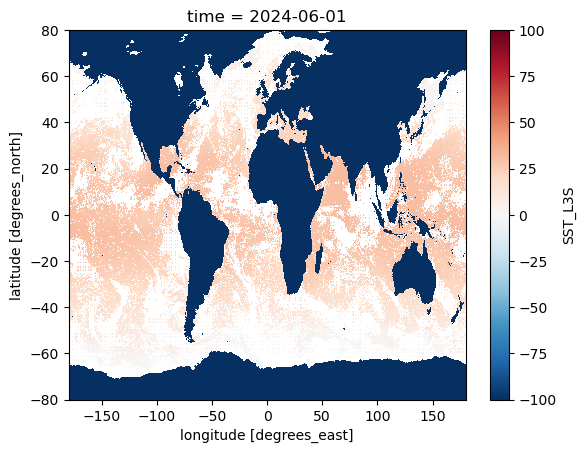

In [10]:
ds['SST_L3S'].plot(y='latitude',x='longitude')

# Convert data in HEALPix

## we need to add what is DGGS ands healpix here

In [11]:
# define the healpix resolution
nside = 128
nest = True
full_cell_ids = range(0, 12*nside**2)

In [12]:
ds_healpix=(ds
    .stack(id=('latitude', 'longitude'))
    .chunk('auto')
   ).persist()
ds_healpix['latitude_cp']=ds_healpix['latitude']
ds_healpix['longitude_cp']=ds_healpix['longitude']
th=(90.0-ds_healpix['latitude'])/180.0*np.pi
ph=2*np.pi-(ds_healpix['longitude'])/180.0*np.pi
cell_ids=hp.ang2pix(nside,th.data,ph.data,nest=nest)
ds_healpix=ds_healpix.persist()

#group by the mask, and take mean, 
#including np.nan values, to keep the trace of all missing values. 
ds_mask=ds_healpix[["mask"]].assign_coords({
        'cell_ids':(["id"],cell_ids)}).sortby('cell_ids'
                                  ).groupby('cell_ids'
                                           ).mean(skipna=False,keep_attrs=True).compute()
ds_mask

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 89.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.Dataset>
Dimensions:   (cell_ids: 193800, time: 1)
Coordinates:
  * time      (time) datetime64[ns] 2024-06-01
  * cell_ids  (cell_ids) int64 0 1 2 3 4 ... 196603 196604 196605 196606 196607
Data variables:
    mask      (cell_ids, time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA Global H...
    cmems_product_id:                SST_GLO_PHY_L4_NRT_010_043
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2024-02-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-02-05T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            1d893532-b9bb-4bc7-88e0-bb3bf619b72b

In [13]:
#group by the mask, and take mean, 
#skipping np.nan values, so that temperature data does not get affected. 

#ATT, may be i should use ocean mask before groupby?
ds_healpix=ds_healpix[["SST_L3S",'latitude_cp',"longitude_cp","SST_L4"
                      ]].assign_coords({
        'cell_ids':(["id"],cell_ids)}).sortby('cell_ids'
                                  ).groupby('cell_ids'
                                           ).mean(skipna=True,keep_attrs=True)
ds_healpix["ocean"]=xr.where(ds_mask["mask"]==1,True,False)
ds_healpix['clouds']=ds_healpix.SST_L3S.isnull()

#'check if there is any forgotten latitude or longiguted, if zero, it is ok.'
print(ds_healpix.latitude_cp.isnull().sum().data,ds_healpix.longitude_cp.isnull().sum().data)
print(ds_healpix.ocean.sum().compute().data,ds_healpix.clouds.sum().compute().data)

ds_healpix

0 0


/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 89.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


126054 16023


<xarray.Dataset>
Dimensions:       (cell_ids: 193800, time: 1)
Coordinates:
  * time          (time) datetime64[ns] 2024-06-01
  * cell_ids      (cell_ids) int64 0 1 2 3 4 ... 196604 196605 196606 196607
Data variables:
    SST_L3S       (cell_ids, time) float32 dask.array<chunksize=(193800, 1), meta=np.ndarray>
    latitude_cp   (cell_ids) float32 0.3 0.6 0.6 0.9 ... -0.9 -0.6 -0.6 -0.3
    longitude_cp  (cell_ids) float32 -45.0 -45.35 -44.65 ... 44.65 45.35 45.0
    SST_L4        (cell_ids, time) float32 dask.array<chunksize=(193800, 1), meta=np.ndarray>
    ocean         (cell_ids, time) bool True True True True ... True True True
    clouds        (cell_ids, time) bool dask.array<chunksize=(193800, 1), meta=np.ndarray>
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA Global H...
    cmems_product_id:                SST_GLO_PHY_L4_NRT_010_043
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2024-02-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-02-05T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            1d893532-b9bb-4bc7-88e0-bb3bf619b72b

In [14]:
ds_healpix=ds_healpix.reindex(cell_ids=full_cell_ids, fill_value=False)
ds_healpix=ds_healpix.persist()

ds_healpix.cell_ids.attrs = {
    "grid_name": "healpix",
    "nside": nside,
    "nest": nest,
}

ds_healpix=ds_healpix.reset_index('cell_ids').set_xindex("cell_ids", xdggs.DGGSIndex).dggs.assign_latlon_coords()
print(ds_healpix.latitude_cp.isnull().sum().data,ds_healpix.longitude_cp.isnull().sum().data)
print(ds_healpix.ocean.sum().compute().data,ds_healpix.clouds.sum().compute().data)
ds_healpix

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 140.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


0 0
126054 16023


<xarray.Dataset>
Dimensions:       (time: 1, cell_ids: 196608)
Coordinates:
  * time          (time) datetime64[ns] 2024-06-01
  * cell_ids      (cell_ids) int64 0 1 2 3 4 ... 196604 196605 196606 196607
    latitude      (cell_ids) float64 0.2984 0.5968 0.5968 ... -0.5968 -0.2984
    longitude     (cell_ids) float64 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables:
    SST_L3S       (cell_ids, time) float32 dask.array<chunksize=(196608, 1), meta=np.ndarray>
    latitude_cp   (cell_ids) float32 0.3 0.6 0.6 0.9 ... -0.9 -0.6 -0.6 -0.3
    longitude_cp  (cell_ids) float32 -45.0 -45.35 -44.65 ... 44.65 45.35 45.0
    SST_L4        (cell_ids, time) float32 dask.array<chunksize=(196608, 1), meta=np.ndarray>
    ocean         (cell_ids, time) bool True True True True ... True True True
    clouds        (cell_ids, time) bool dask.array<chunksize=(196608, 1), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=7, indexing_scheme=nested, rotation=[0.0, 0.0])
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA Global H...
    cmems_product_id:                SST_GLO_PHY_L4_NRT_010_043
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2024-02-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-02-05T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            1d893532-b9bb-4bc7-88e0-bb3bf619b72b

In [15]:
ds_healpix.to_zarr('healpix2.zarr',mode='w')

In [4]:
ds_healpix=xr.open_dataset('healpix2.zarr').isel(time=0)
ds_healpix

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:       (cell_ids: 196608)
Coordinates:
  * cell_ids      (cell_ids) int64 0 1 2 3 4 ... 196604 196605 196606 196607
    latitude      (cell_ids) float64 ...
    longitude     (cell_ids) float64 ...
    time          datetime64[ns] 2024-06-01
Data variables:
    SST_L3S       (cell_ids) float32 ...
    SST_L4        (cell_ids) float32 ...
    clouds        (cell_ids) bool ...
    latitude_cp   (cell_ids) float32 ...
    longitude_cp  (cell_ids) float32 ...
    ocean         (cell_ids) bool ...
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA Global H...
    cmems_product_id:                SST_GLO_PHY_L4_NRT_010_043
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2024-02-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-02-05T12:00:00Z
    title:                           ODYSSEA Global Sea Surface Temperature G...
    uuid:                            1d893532-b9bb-4bc7-88e0-bb3bf619b72b

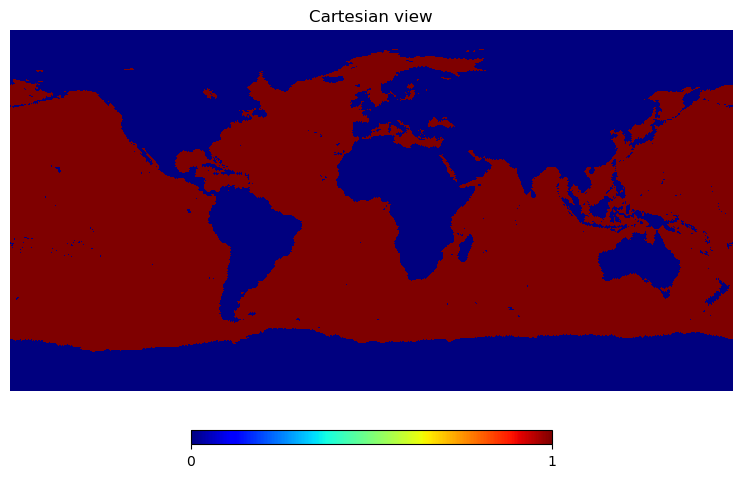

In [5]:
hp.cartview(ds_healpix.ocean.compute().data,cmap='jet',nest=True)

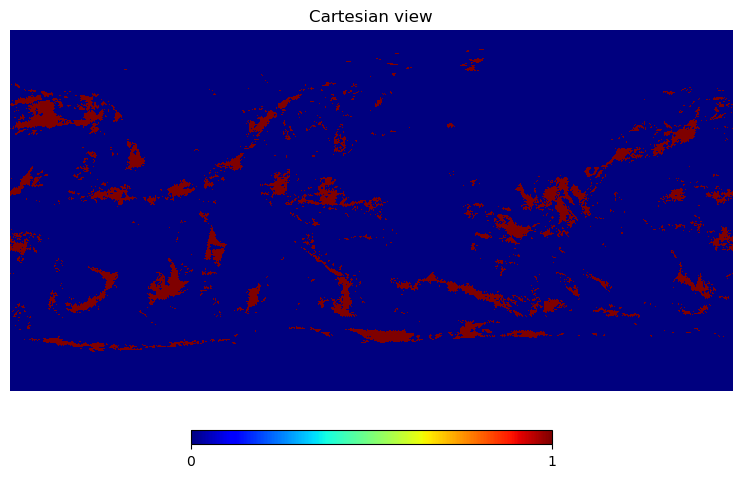

In [6]:
hp.cartview(ds_healpix.clouds.compute().data,cmap='jet',nest=True)

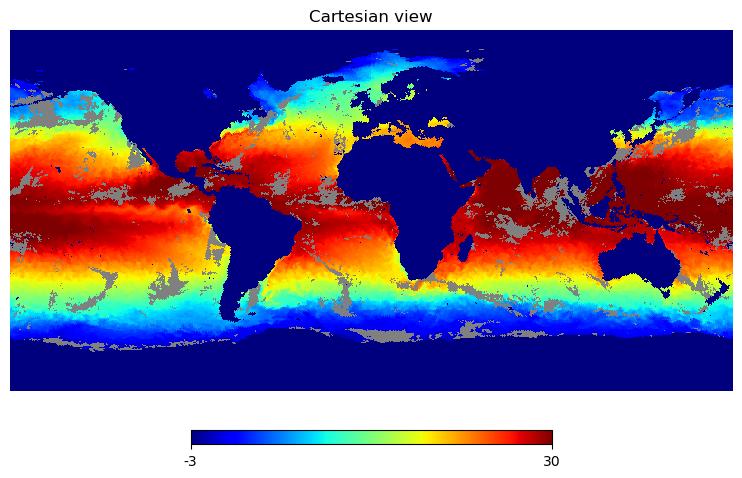

In [7]:
hp.cartview(ds_healpix.SST_L3S.where(ds_healpix.ocean,-100).compute().data,cmap='jet',nest=True,min=-3,max=30)

## Here explain how we do the 'general' filling clouds;
-  np.nan on xarray using linear fitting we can update it with xarray.polyfit?
-  we can also use liner fitting of xarray here? ( we can fit it when it is in lat lon coordinate in the step before probably?) 

In [8]:
# we chose only the part we have SST value as 'sst_to_fit' and coordinate 'lat_to_fit' so that we do polynomial fit of SST against latitude.

sst_to_fit=ds_healpix.SST_L3S.where(ds_healpix.ocean & ~(ds_healpix.clouds)).dropna(dim='cell_ids')#.compute().data
lat_to_fit=sst_to_fit.latitude
print('total observed ocean value ', lat_to_fit.count().compute().data)


# we estimate the all coordinate without SST value, we can of course estimate only the points where it is 'clouds' but as we will need to 
#'fill val' for next scattering process, we fill all the points including the 'ground'
sst_for_fill=ds_healpix.where(~(ds_healpix.ocean & ~ds_healpix.clouds),drop=True)
lat_for_fill=sst_for_fill.latitude
print('total clouds/land etc to fill is ', lat_for_fill.count().compute().data)



total observed ocean value  110031
total clouds/land etc to fill is  86577


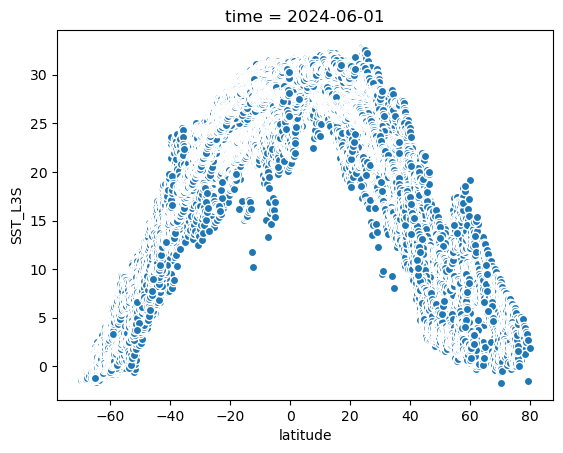

In [9]:
sst_to_fit.plot.scatter(x='latitude')


In [10]:
#fit coef, and create compute the missing sst values.
fit_coef=np.polyfit(lat_to_fit.compute().data,sst_to_fit.compute().data,2)
sst_for_fill_data=fit_coef[0]*lat_for_fill.data**2+fit_coef[1]*lat_for_fill.data+fit_coef[2]

#Put the computed values in the  SST_L3S and save the result in a Data Aray SST_polyfit_filled
ds_healpix['SST_polyfit_filled']=ds_healpix['SST_L3S'].copy()
ds_healpix['SST_polyfit_filled'].loc[{"cell_ids": lat_for_fill.cell_ids}] = sst_for_fill_data

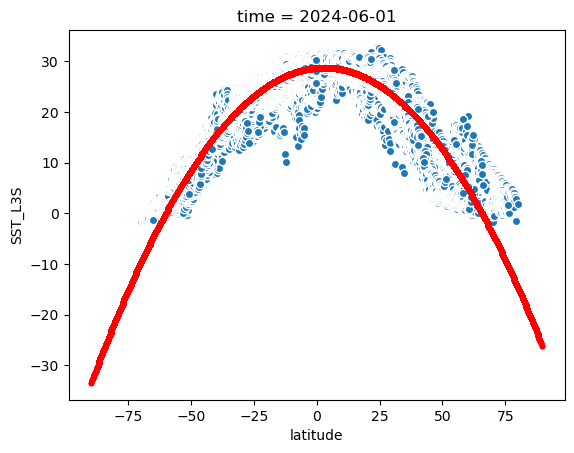

In [11]:
fig, ax = plt.subplots()

# Scatter plot
sst_to_fit.plot.scatter(x='latitude', y='sst', ax=ax)

# Line plot
#ax.plot(t[mask[0]], tmp[mask[0]], '.', color='r')
ax.plot(lat_for_fill.data,sst_for_fill_data,'.', color='r')
# Display the plot
plt.show()

# Plot the poly_fit results

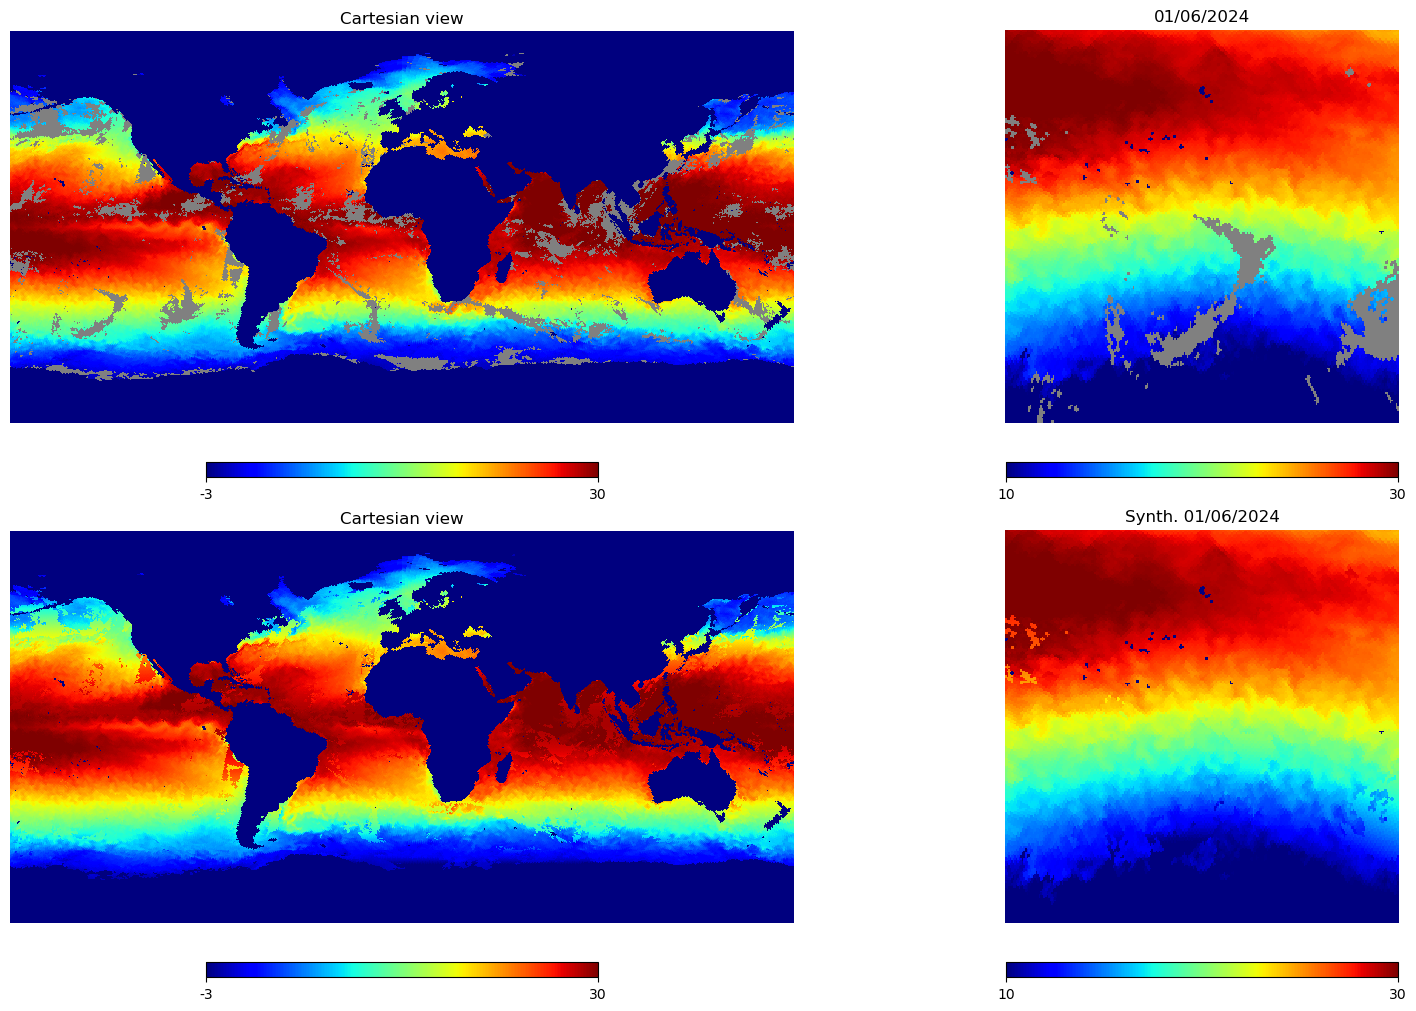

In [12]:
plt.figure(figsize=(16,10))
hp.cartview(ds_healpix.SST_L3S.where(ds_healpix.ocean,-100).compute().data,nest=True,min=-3,max=30,cmap='jet',hold=False,sub=(2,2,1))
hp.cartview(ds_healpix.SST_polyfit_filled.where(ds_healpix.ocean,-100).compute().data,nest=True,min=-3,max=30,cmap='jet',hold=False,sub=(2,2,3))
hp.gnomview(ds_healpix.SST_L3S.where(ds_healpix.ocean,-100).compute().data,nest=True,min=10,max=30,cmap='jet',rot=[140,-30],reso=15,notext=True,
            title='01/06/2024',hold=False,sub=(2,2,2),xsize=256)
hp.gnomview(ds_healpix.SST_polyfit_filled.where(ds_healpix.ocean,-100).compute().data,nest=True,min=10,max=30,cmap='jet',rot=[140,-30],reso=15,notext=True,
            title='Synth. 01/06/2024',hold=False,sub=(2,2,4),xsize=256)

## Apply scattering transform, 

#### learning process to fill the data.  

In this process, we will learn the process from the observed SST.  We need to fill the value with first naive 'guess', thus we start the learning process from ds_healpix.SST_polyfit_filled
- learn the property from observed SST (ocean area but without clouds) 
  ds_healpix.SST_polyfit_filled.where((ds_healpix.ocean & ~(ds_healpix.clouds)))
- compute the gradiant for the clouds area
  ds_healpix.SST_polyfit_filled.where( ~(ds_healpix.clouds)))
- We apply scattering transform for all oceanic area
  
  

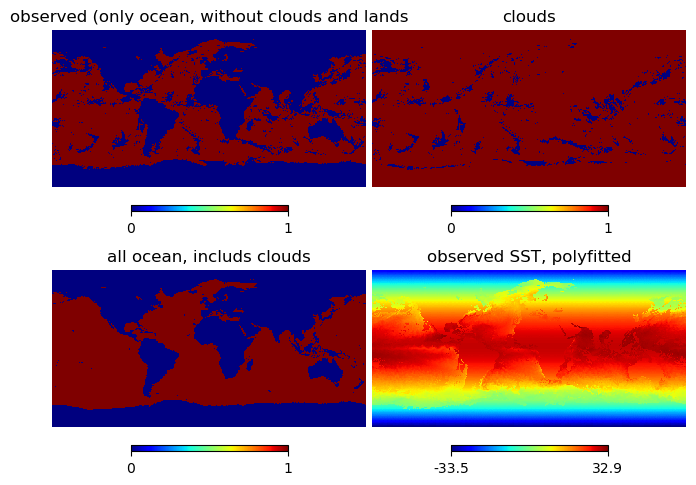

In [13]:
hp.cartview(xr.where( (ds_healpix.ocean & ~ds_healpix.clouds),1,0).compute().data,cmap='jet',nest=True,title='observed (only ocean, without clouds and lands',sub=(2,2,1))#,min=-3,max=30)
hp.cartview(xr.where( ~(ds_healpix.clouds),1,0).compute().data,cmap='jet',nest=True,title='clouds',sub=(2,2,2))
hp.cartview(xr.where( (ds_healpix.ocean),1,0).compute().data,cmap='jet',nest=True,title='all ocean, includs clouds',sub=(2,2,3))
#hp.cartview(ds_healpix.SST_polyfit_filled.where( (ds_healpix.ocean & ~ds_healpix.clouds),-100).compute().data,cmap='jet',nest=True,title='observed SST',sub=(2,2,4),min=-3,max=30)
hp.cartview(ds_healpix.SST_polyfit_filled.compute().data,cmap='jet',nest=True,title='observed SST, polyfitted',sub=(2,2,4))#,min=-30,max=30)

In [14]:
#We set up foscat;


scat=sc.funct(silent=True, 
              JmaxDelta=4,        # The used Jmax is Jmax-JmaxDelta
              mask_norm=True,          # normalize mask
              mask_thres=0.7)



2024-06-13 22:25:58.284312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


2024-06-13 22:26:01.485749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43821 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:27:00.0, compute capability: 8.6


In [15]:
#our data to apply foscat
data=ds_healpix.SST_polyfit_filled.compute().data#.reshape(1,ds_healpix.cell_ids.size)#.where(ds_healpix.ocean & ~(ds_healpix.clouds))
print(data.shape)


# here we mask non ocean point as 0
# cloud is 0, only observed points are 1. 
mask_observe_only=(ds_healpix.ocean & ~(ds_healpix.clouds)).data.reshape(1,ds_healpix.cell_ids.size)
print(mask_observe_only.shape)

print(data.shape, mask_observe_only.shape)

ref=scat.eval(data,mask=mask_observe_only)

(196608,)
(1, 196608)
(196608,) (1, 196608)


In [16]:
def The_loss_function(x,scat_operator,args,return_all=False):

    ref = args[0]
    mask = args[1]

    learn=scat_operator.eval(x,mask=mask)

    loss=scat_operator.reduce_mean(scat_operator.square((ref-learn)/ref))

    return(loss)
# all the cloud is one. 
#
grd_mask=data[0]==hp.UNSEEN, 
#mask it as 1.0 if it is cloud. 
# here we mask non ocean point as 0
# all ocean points are 1. 
mask_all_ocean=(ds_healpix.ocean).data.reshape(1,ds_healpix.cell_ids.size)

print(mask_all_ocean.shape)


loss=synthe.Loss(The_loss_function,scat,ref,
                 scat.backend.constant(scat.backend.bk_cast(mask_all_ocean)))

sy = synthe.Synthesis([loss])

(1, 196608)


In [27]:
#=================================================================================
# RUN ON SYNTHESIS
#=================================================================================
# here we 
# cloud as 1, because we want to compute gradient at clouds
# all the other points are 0
mask_clouds_only=((ds_healpix.clouds)).data.reshape(1,ds_healpix.cell_ids.size)
print(mask_clouds_only.shape)


omap=sy.run(scat.backend.bk_cast(data),
            EVAL_FREQUENCY=100,
            grd_mask=mask_clouds_only, # only the gradient of masked data is computed
            NUM_EPOCHS = 1000).numpy()

(1, 196608)
Total number of loss  1
Itt      0 L=     0.229 (     0.229 ) 0.071s 
Itt    100 L=  0.000419 (  0.000419 ) 9.031s 
Itt    200 L=  0.000132 (  0.000132 ) 8.380s 
Itt    300 L=  6.03e-05 (  6.03e-05 ) 8.667s 
Itt    400 L=  3.05e-05 (  3.05e-05 ) 8.289s 
Itt    500 L=  1.92e-05 (  1.92e-05 ) 8.340s 
Itt    600 L=   1.4e-05 (   1.4e-05 ) 8.270s 
Itt    700 L=   9.9e-06 (   9.9e-06 ) 8.243s 
Itt    800 L=  7.77e-06 (  7.77e-06 ) 8.389s 
Itt    900 L=  6.37e-06 (  6.37e-06 ) 8.250s 
Itt   1000 L=  5.29e-06 (  5.29e-06 ) 8.095s 


In [39]:
#Put the computed values in the  SST_L3S and save the result in a Data Aray SST_foscat_filled
ds_healpix['SST_foscat_filled']=ds_healpix['SST_L3S'].copy()
ds_healpix['SST_foscat_filled'].loc[:] = omap

# Plot the results


## Comparision with L4 product, SST_polyfit_filled

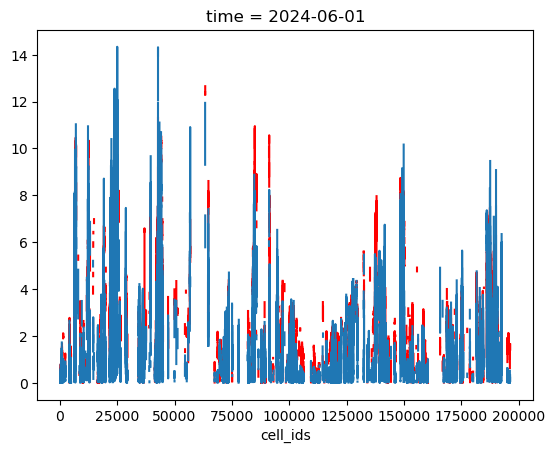

In [66]:
fig, ax = plt.subplots()


# Scatter plot
abs(ds_healpix.SST_L4-ds_healpix.SST_polyfit_filled).where(ds_healpix.clouds).plot(ax=ax,color='r')
abs(ds_healpix.SST_L4-ds_healpix.SST_foscat_filled).where(ds_healpix.clouds).plot(ax=ax)

plt.show()

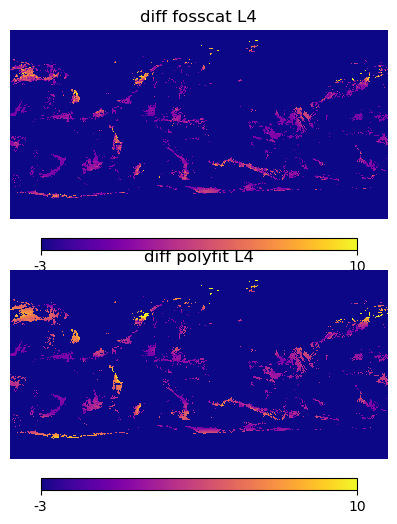

In [75]:

hp.cartview(
    (abs(ds_healpix.SST_L4-ds_healpix.SST_foscat_filled)).where(ds_healpix.clouds,-100).compute().data,
             nest=True,cmap='plasma',min=-3,max=10,sub=(2,1,1),title='diff fosscat L4')
hp.cartview(
    (abs(ds_healpix.SST_L4-ds_healpix.SST_polyfit_filled)).where(ds_healpix.clouds,-100).compute().data,
             nest=True,cmap='plasma',min=-3,max=10,sub=(2,1,2),title='diff polyfit L4')


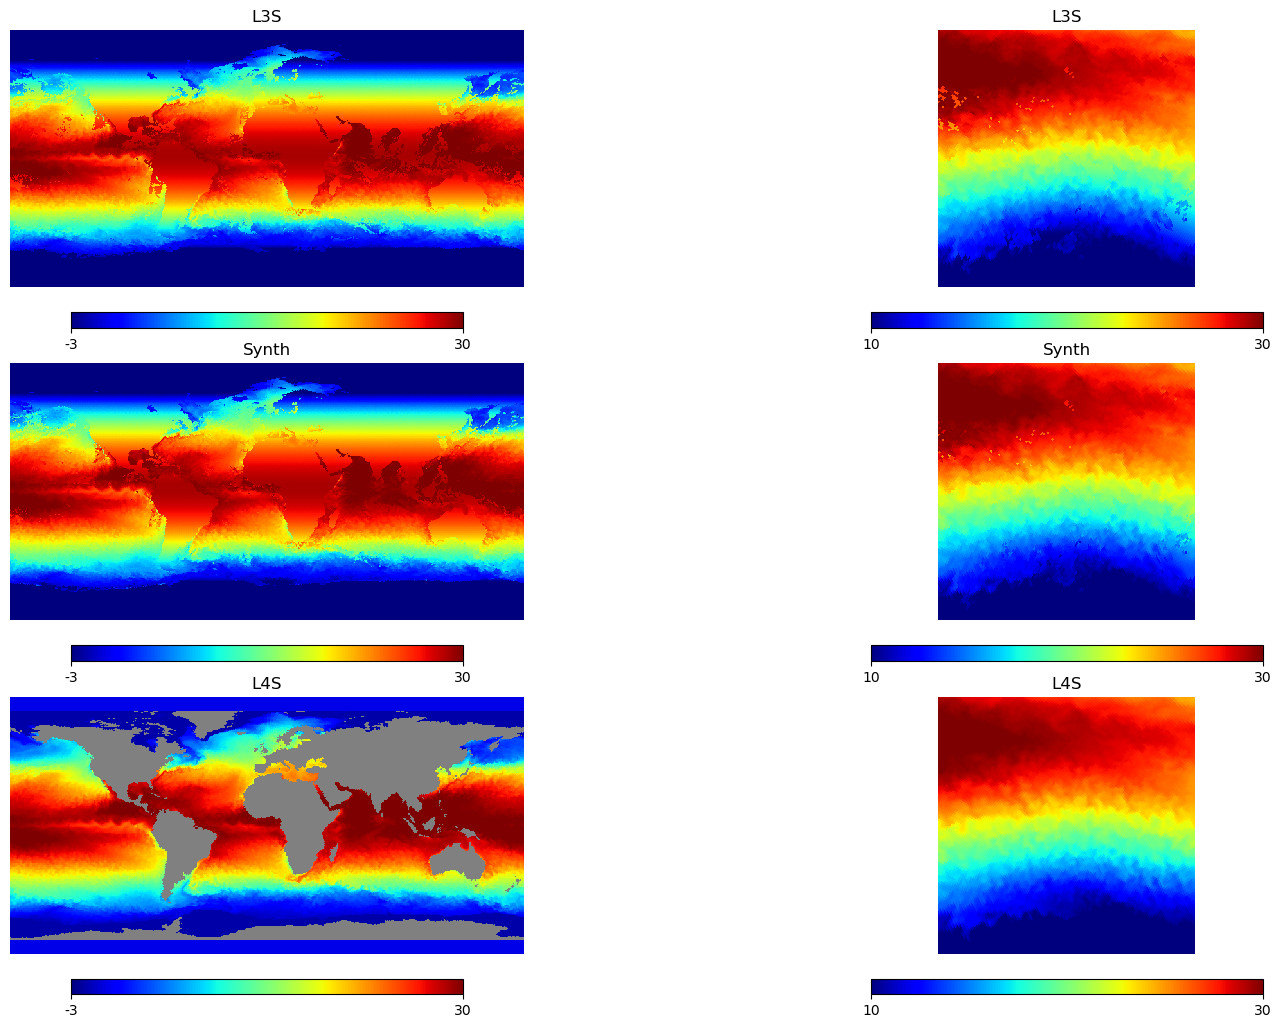

In [35]:
plt.figure(figsize=(16,10))
hp.cartview(data,nest=True,min=-3,max=30,cmap='jet',
            title='L3S'
            ,hold=False,sub=(3,2,1))
hp.cartview(omap,nest=True,min=-3,max=30,cmap='jet',
             title='Synth'
            ,hold=False,sub=(3,2,3))
hp.cartview(ds_healpix.SST_L4.compute().data,nest=True,min=-3,max=30
            ,cmap='jet',
             title='L4S'
            ,hold=False,sub=(3,2,5))

hp.gnomview(data,nest=True,min=10,max=30,cmap='jet',rot=[140,-30],reso=15,notext=True,
            title='L3S',hold=False,sub=(3,2,2),xsize=256)
hp.gnomview(omap,nest=True,min=10,max=30,cmap='jet',rot=[140,-30],reso=15,notext=True,
            title='Synth',hold=False,sub=(3,2,4),xsize=256)
hp.gnomview(ds_healpix.SST_L4.compute().data,nest=True,min=10,max=30,cmap='jet',rot=[140,-30],reso=15,notext=True,
            title='L4S',hold=False,sub=(3,2,6),xsize=256)

